In [5]:
%pip install nltk
%pip install lxml
%pip install -U scikit-learn


import collections
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import email
from bs4 import BeautifulSoup


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Load the dataset
df = pd.read_csv('data.csv')
print(df.shape)
all_words = ' '.join(df['origin'])
words = all_words.split()
word_counts = collections.Counter(words)

for word, count in word_counts.most_common(50):
    print(f'{word}: {count}')

(33702, 2)
.: 523676
-: 407610
,: 384309
the: 290733
to: 212996
/: 173367
:: 168458
and: 157454
of: 148441
a: 118033
in: 106567
for: 84410
you: 82063
': 79743
is: 71527
_: 69078
this: 63848
enron: 60909
on: 59509
that: 56854
i: 56472
): 56163
(: 52884
s: 52505
": 49173
with: 47615
@: 47476
your: 47407
be: 46996
?: 44790
we: 43455
$: 42551
!: 42500
as: 40273
from: 39543
have: 39031
it: 38600
will: 38378
are: 37203
>: 36914
ect: 35346
or: 34610
Subject:: 33702
at: 33071
by: 31392
not: 29502
;: 28838
our: 25563
com: 24179
if: 23809


In [7]:
def read_email_from_string(s):
    message = email.message_from_string(s)
    return message

def extract_email_body(message):
    if message.is_multipart():
        for part in message.walk():
            type_content = part.get_content_maintype()
            if type_content == 'text':
                message = part
                break
        else:
            return ''
    body = message.get_payload(decode=False)
    return body



def remove_html(s):
    soup = BeautifulSoup(s, 'lxml')
    for sp in soup(['script', 'style', 'head', 'meta', 'noscript', 'http']):
        sp.decompose()
    s = ' '.join(soup.stripped_strings)
    return s


# Function to preprocess text
def preprocess_text(text):
    # Extract email body
    body = extract_email_body(read_email_from_string(text))
    body = remove_html(body)

    # Tokenize the text
    words = nltk.word_tokenize(body)

    # Remove punctuation and convert to lower case
    words = [word.lower() for word in words if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    specific_words = ['enron', 'e', 'hou', 'subject']
    words = [word for word in words if word not in specific_words]


    words = [lemmatizer.lemmatize(word) for word in words]
    words = [word for word in words]

    
    return ' '.join(words)

df['clean'] = df['origin'].apply(preprocess_text)

# Save the refactored emails back to the same file
df.to_csv('preprocessed.csv', index=False)

C:\Users\Martin\AppData\Local\Temp\ipykernel_4128\3576705020.py:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(s, 'lxml')


In [8]:
df.head()
df.tail()


,label,origin,clean
33697,1,Subject: friendly notification\n\nthis is our ...,absolute notice aimed make contact multiple op...
33698,1,Subject: i promised to help 5000 people\n\nple...,please refer question opinion additional feedb...
33699,1,Subject: next big mover set to skyrocket\n\nse...,secured data inc scre emerging leader chinese ...
33700,1,Subject: work\n\nin virtue of my office as ass...,virtue office assistant professor museum natur...
33701,1,"Subject: \\ / allum $ 75 , xanaax $ 75 , ciall...",unfelt tyrannize branchlet courtierly jettison...


In [9]:
from collections import Counter

def get_top_words(df, label, n=20):
  """
  This function finds the n most common words in emails belonging to a specific label (spam or non-spam).

  Args:
      df (pandas.DataFrame): The dataframe containing the data.
      label (int): The label value (1 for spam, 0 for non-spam).
      n (int, optional): The number of most common words to return. Defaults to 20.

  Returns:
      list: A list containing the n most common words for the specified label.
  """
  spam_emails = df[df['label'] == label]['clean']
  all_words = ' '.join(spam_emails)
  word_counts = Counter(all_words.split())
  return word_counts.most_common(n)

# Find most common words in spam emails
spam_words = get_top_words(df.copy(), 1)

# Find most common words in non-spam emails
non_spam_words = get_top_words(df.copy(), 0)

# Print the results (optional)
print("Top 20 Words in Spam Emails:")
print(spam_words)

print("\nTop 20 Words in Non-Spam Emails:")
print(non_spam_words)

Top 20 Words in Spam Emails:
[('company', 13880), ('com', 11540), ('u', 9048), ('http', 8754), ('email', 8467), ('information', 7715), ('please', 7179), ('statement', 6913), ('price', 6787), ('security', 6366), ('may', 6182), ('one', 6080), ('time', 5945), ('business', 5735), ('de', 5730), ('get', 5479), ('www', 5370), ('money', 5289), ('stock', 5179), ('mail', 5146)]

Top 20 Words in Non-Spam Emails:
[('ect', 35324), ('company', 14682), ('please', 12939), ('would', 12509), ('com', 12389), ('said', 10833), ('energy', 9630), ('new', 9508), ('pm', 9379), ('cc', 9283), ('gas', 8885), ('deal', 8698), ('time', 8601), ('vince', 8531), ('market', 8328), ('power', 7542), ('business', 7519), ('year', 7460), ('corp', 7420), ('know', 7194)]


Number of Spam Emails: 17157
Number of Non-Spam Emails: 16545
Total Emails: 33702
Percentage of Spam Emails: 50.91%
Percentage of Non-Spam Emails: 49.09%


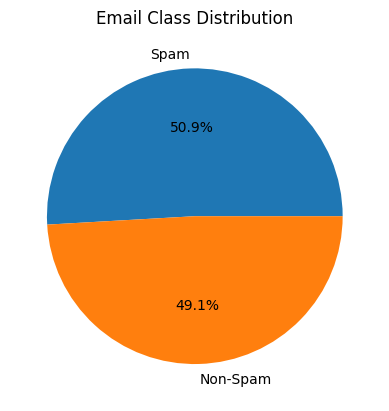

In [10]:
spam_count = len(df[df['label'] == 1])
non_spam_count = len(df[df['label'] == 0])
total_count = len(df)

print(f"Number of Spam Emails: {spam_count}")
print(f"Number of Non-Spam Emails: {non_spam_count}")
print(f"Total Emails: {total_count}")

# Calculate percentage
spam_percent = (spam_count / total_count) * 100
non_spam_percent = (non_spam_count / total_count) * 100

print(f"Percentage of Spam Emails: {spam_percent:.2f}%")
print(f"Percentage of Non-Spam Emails: {non_spam_percent:.2f}%")

# Visualization (using matplotlib)
import matplotlib.pyplot as plt

plt.pie([spam_percent, non_spam_percent], labels=['Spam', 'Non-Spam'], autopct="%1.1f%%")
plt.title("Email Class Distribution")
plt.show()

In [11]:
! pip install seaborn


[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Spam Lengths: 17157
Non-Spam Lengths: 16545


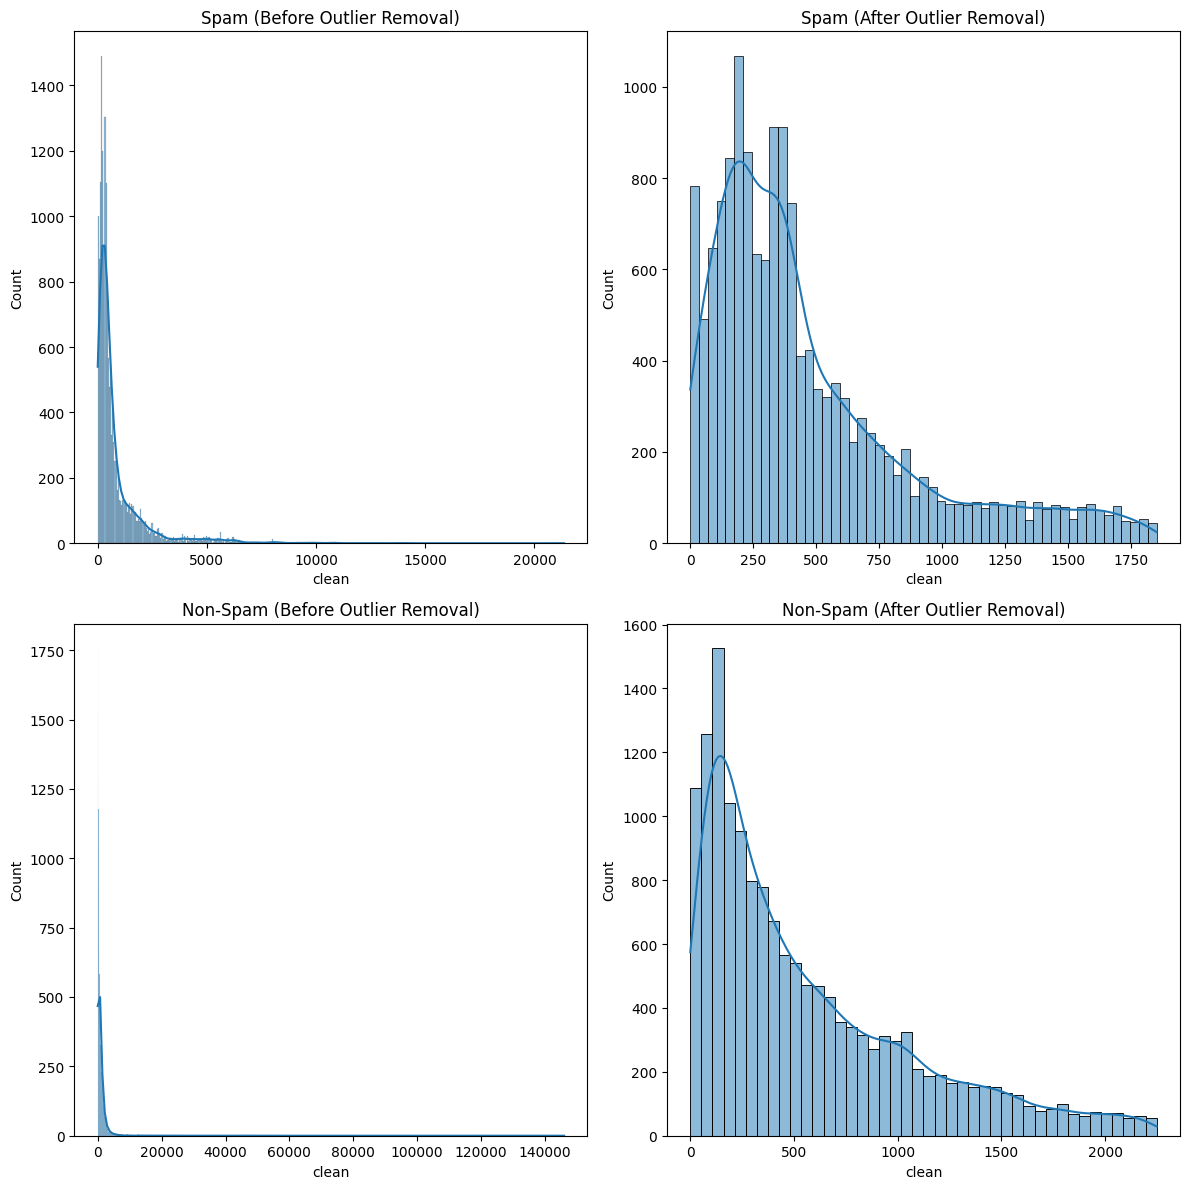

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def get_iqr_outliers(data):
  """
  This function identifies outliers in a data series using IQR.

  Args:
      data (pandas.Series): The data series containing email lengths.

  Returns:
      tuple: A tuple containing the inlier data and outlier data (as separate pandas.Series).
  """
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1
  upper_bound = q3 + 1.5 * iqr
  lower_bound = q1 - 1.5 * iqr
  inliers = data[(data >= lower_bound) & (data <= upper_bound)]
  outliers = data[(data < lower_bound) | (data > upper_bound)]
  return inliers, outliers

# Calculate email lengths for spam and non-spam
spam_lengths = df[df['label'] == 1]['clean'].str.len()
non_spam_lengths = df[df['label'] == 0]['clean'].str.len()

# Print data lengths for debugging (optional)
print("Spam Lengths:", len(spam_lengths))
print("Non-Spam Lengths:", len(non_spam_lengths))

# Create subplots for side-by-side comparison

fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Adjust figsize for better visualization

# Check for empty data before plotting (optional)
if len(spam_lengths) == 0 or len(non_spam_lengths) == 0:
  print("Warning: Empty data for spam or non-spam lengths. Plots might be empty.")
else:
  # Plot distribution before outlier removal
  sns.histplot(spam_lengths, kde=True, ax=axs[0, 0])
  axs[0, 0].set_title("Spam (Before Outlier Removal)")

  sns.histplot(non_spam_lengths, kde=True, ax=axs[1, 0])
  axs[1, 0].set_title("Non-Spam (Before Outlier Removal)")

  # Apply IQR to identify outliers
  spam_inliers, spam_outliers = get_iqr_outliers(spam_lengths)
  non_spam_inliers, non_spam_outliers = get_iqr_outliers(non_spam_lengths)

  # Filter DataFrames based on inliers
  filtered_df_spam = df[df['label'] == 1].loc[spam_inliers.index]
  filtered_df_non_spam = df[df['label'] == 0].loc[non_spam_inliers.index]

  # Check for empty data after filtering (optional)
  if len(filtered_df_spam) == 0 or len(filtered_df_non_spam) == 0:
    print("Warning: Filtering removed all data. Plots might be empty.")
  else:
    # Plot distribution after outlier removal
    sns.histplot(filtered_df_spam['clean'].str.len(), kde=True, ax=axs[0, 1])
    axs[0, 1].set_title("Spam (After Outlier Removal)")

    sns.histplot(filtered_df_non_spam['clean'].str.len(), kde=True, ax=axs[1, 1])
    axs[1, 1].set_title("Non-Spam (After Outlier Removal)")

# Adjust layout (optional)
plt.tight_layout()
plt.show()


In [13]:
# Function to extract n-grams (bigrams and trigrams)
def get_n_grams(text, n):
  n_grams = []
  words = text.split()
  for i in range(len(words) - n + 1):
    n_gram = " ".join(words[i:i+n])
    n_grams.append(n_gram)
  return n_grams

# Create dictionaries to store n-gram frequencies for spam and non-spam
bigram_counts_spam = {}
trigram_counts_spam = {}
bigram_counts_non_spam = {}
trigram_counts_non_spam = {}

for i, row in df.iterrows():
  text = row['clean']
  # Extract bigrams and trigrams
  bigrams = get_n_grams(text, 2)
  trigrams = get_n_grams(text, 3)
  # Check label (spam or non-spam)
  if row['label'] == 1:
    # Update spam n-gram counts
    for bigram in bigrams:
      if bigram in bigram_counts_spam:
        bigram_counts_spam[bigram] += 1
      else:
        bigram_counts_spam[bigram] = 1
    for trigram in trigrams:
      if trigram in trigram_counts_spam:
        trigram_counts_spam[trigram] += 1
      else:
        trigram_counts_spam[trigram] = 1
  else:
    # Update non-spam n-gram counts
    for bigram in bigrams:
      if bigram in bigram_counts_non_spam:
        bigram_counts_non_spam[bigram] += 1
      else:
        bigram_counts_non_spam[bigram] = 1
    for trigram in trigrams:
      if trigram in trigram_counts_non_spam:
        trigram_counts_non_spam[trigram] += 1
      else:
        trigram_counts_non_spam[trigram] = 1

In [14]:
# Top 10 Bigrams (Spam)
print("Top 10 Bigrams (Spam):")
top_10_bigrams_spam = Counter(bigram_counts_spam).most_common(10)
for bigram, count in top_10_bigrams_spam:
  print(f"{bigram}: {count}")

# Top 10 Trigrams (Spam)
print("\nTop 10 Trigrams (Spam):")
top_10_trigrams_spam = Counter(trigram_counts_spam).most_common(10)
for trigram, count in top_10_trigrams_spam:
  print(f"{trigram}: {count}")

# Top 10 Bigrams (Non-Spam)
print("\n\nTop 10 Bigrams (Non-Spam):")
top_10_bigrams_non_spam = Counter(bigram_counts_non_spam).most_common(10)
for bigram, count in top_10_bigrams_non_spam:
  print(f"{bigram}: {count}")

# Top 10 Trigrams (Non-Spam)
print("\nTop 10 Trigrams (Non-Spam):")
top_10_trigrams_non_spam = Counter(trigram_counts_non_spam).most_common(10)
for trigram, count in top_10_trigrams_non_spam:
  print(f"{trigram}: {count}")


Top 10 Bigrams (Spam):
http www: 3734
looking statement: 2195
forward looking: 1918
investment advice: 1486
email address: 1482
within email: 1134
information provided: 1031
would like: 1030
risk uncertainty: 1029
united state: 989

Top 10 Trigrams (Spam):
forward looking statement: 1856
statement within meaning: 756
www computron com: 661
security act section: 589
forward ooking statement: 562
phone mobile email: 557
security exchange act: 549
act section b: 548
within meaning section: 537
number risk uncertainty: 529


Top 10 Bigrams (Non-Spam):
ect ect: 15770
let know: 3975
original message: 3869
ect cc: 3799
j kaminski: 3338
vince j: 3321
dow jones: 2979
would like: 2443
new york: 2359
please let: 2271

Top 10 Trigrams (Non-Spam):
ect ect cc: 3697
vince j kaminski: 3301
please let know: 1998
j kaminski ect: 1945
lon ect ect: 1707
dow jones company: 1437
jones company inc: 1437
copyright dow jones: 1412
kaminski ect ect: 1369
unknown database alias: 1332


In [15]:
# Shuffle data for better randomization
df = df.sample(frac=1, random_state=1)

# Split into training and other sets (70/30)

train_df, other_df = train_test_split(df, test_size=0.3, random_state=1)

# Further split other data into validation and testing sets (66.67/33.33 within other data)
val_df, test_df = train_test_split(other_df, test_size=0.33, random_state=1)

# No need to reset index here (can be done later if required)

X_train = train_df['clean']
y_train = train_df['label']

X_val = val_df['clean']
y_val = val_df['label']

X_test = test_df['clean']
y_test = test_df['label']

print(len(X_train))
print(len(X_val))
print(len(X_test))

23591
6774
3337


In [16]:
# Count tokens in training set
token_counter = {}
for message in train_df['clean']:
  words = nltk.word_tokenize(message)

  for token in words:
    if token in token_counter:
      token_counter[token] += 1
    else:
      token_counter[token] = 1

token_counter

{'thank': 2536,
 'pam': 102,
 'wrote': 359,
 'another': 1613,
 'term': 4220,
 'paper': 1188,
 'john': 2799,
 'ganguzza': 7,
 'neeraj': 4,
 'hingorani': 4,
 'grant': 801,
 'johnson': 331,
 'duane': 58,
 'maue': 7,
 'rishad': 7,
 'patel': 49,
 'eric': 371,
 'van': 277,
 'stone': 199,
 'palo': 163,
 'yoshiuro': 1,
 'grade': 499,
 'please': 13960,
 'confirm': 677,
 'vince': 5977,
 'see': 4756,
 'went': 470,
 'happy': 783,
 'meet': 1433,
 'jinbaek': 108,
 'time': 10301,
 'slot': 94,
 'anyone': 774,
 'else': 617,
 'scheduled': 685,
 'easily': 324,
 'hiim': 2,
 'lunch': 419,
 'molly': 262,
 'forwarded': 2728,
 'magee': 96,
 'ect': 25397,
 'pm': 6695,
 'shawn': 54,
 'grady': 26,
 'j': 4791,
 'kaminski': 3322,
 'stinson': 719,
 'gibner': 439,
 'tanya': 351,
 'tamarchenko': 156,
 'bob': 1074,
 'lee': 503,
 'na': 1311,
 'vasant': 296,
 'shanbhogue': 189,
 'cc': 6585,
 'shirley': 1239,
 'crenshaw': 805,
 'anita': 317,
 'dupont': 130,
 'interview': 1099,
 'schedule': 2579,
 'kim': 384,
 'find': 239

In [17]:
def keep_token(proccessed_token, threshold):
  if proccessed_token not in token_counter:
    return False
  else:
    # Add condition to check length of token
    return token_counter[proccessed_token] > threshold and len(proccessed_token) > 3


In [18]:
# for the current dataset 6000 is a good value which generates a
# set with an acceptable length to be considered a feature set for the
# machine learning algorithms

# this is the Bag of Words approach

features = set()

for token in token_counter:
  if keep_token(token, 6000):
    features.add(token)

features = list(features)
features

['said',
 'energy',
 'also',
 'message',
 'need',
 'security',
 'please',
 'market',
 'business',
 'power',
 'company',
 'email',
 'year',
 'http',
 'mail',
 'would',
 'service',
 'time',
 'price',
 'information',
 'stock',
 'know',
 'deal']

In [19]:
token_to_index_mapping = {t:i for t, i in zip(features, range(len(features)))}
token_to_index_mapping

{'said': 0,
 'energy': 1,
 'also': 2,
 'message': 3,
 'need': 4,
 'security': 5,
 'please': 6,
 'market': 7,
 'business': 8,
 'power': 9,
 'company': 10,
 'email': 11,
 'year': 12,
 'http': 13,
 'mail': 14,
 'would': 15,
 'service': 16,
 'time': 17,
 'price': 18,
 'information': 19,
 'stock': 20,
 'know': 21,
 'deal': 22}

In [20]:
import numpy as np

def message_to_count_vector(message):
  count_vector = np.zeros(len(features))

  processed_list_of_tokens = nltk.word_tokenize(message)

  for token in processed_list_of_tokens:
    if token not in features:
      continue
    index = token_to_index_mapping[token]
    count_vector[index] += 1

  return count_vector

In [21]:
message_to_count_vector(X_train.iloc[1025])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [22]:
# 1 spam; 0 not spam (looking at the array above we expect a 1)
y_train.iloc[1025]

1

In [23]:
def extract_features_and_labels(dataframe):
  # Extract labels and convert to integer type
  labels = dataframe['label'].values.astype(int)

  # Extract messages
  messages = dataframe['clean']
  vector_counts = []

  # Convert each message to a count vector
  for msg in messages:
    vector = message_to_count_vector(msg)
    vector_counts.append(vector)

  # Convert list of count vectors to a numpy array and cast to integer type
  feature_matrix = np.asarray(vector_counts).astype(int)

  return feature_matrix, labels


In [82]:
X_train_BOW, Y_train_BOW = extract_features_and_labels(train_df)

X_val_BOW, Y_val_BOW = extract_features_and_labels(val_df)

X_test_BOW, Y_test_BOW = extract_features_and_labels(test_df)

X_train_BOW.shape, Y_train_BOW.shape, X_test_BOW.shape, Y_test_BOW.shape

((23591, 23), (23591,), (3337, 23), (3337,))

In [83]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train_BOW)

X_train_BOW, X_test_BOW, X_val_BOW = scaler.transform(X_train_BOW), scaler.transform(X_test_BOW), scaler.transform(X_val_BOW)

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2']
}

X_train_val_BOW = np.concatenate((X_train_BOW, X_val_BOW), axis=0)
Y_train_val_BOW = np.concatenate((Y_train_BOW, Y_val_BOW), axis=0)

lrBOW = LogisticRegression(solver='liblinear', max_iter=30000)
grid_search = GridSearchCV(lrBOW, hyperparameters, cv=5)
best_model = grid_search.fit(X_train_val_BOW, Y_train_val_BOW)
best_params = best_model.best_params_
print('Best Parameters:', best_params)
print('Best Score:', best_model.best_score_)
X_train_BOW, X_val_BOW, Y_train_BOW, Y_val_BOW = train_test_split(X_train_val_BOW, Y_train_val_BOW, test_size=0.2, random_state=42)


# Train the model with the best parameters
lrBOW = LogisticRegression(solver='liblinear', max_iter=30000, **best_params)
lrBOW.fit(X_train_BOW, Y_train_BOW)
print(classification_report(Y_val_BOW, lrBOW.predict(X_val_BOW)))


Best Parameters: {'C': 100, 'penalty': 'l2'}
Best Score: 0.7591305779680553
              precision    recall  f1-score   support

           0       0.80      0.70      0.75      3030
           1       0.73      0.83      0.78      3043

    accuracy                           0.76      6073
   macro avg       0.77      0.76      0.76      6073
weighted avg       0.77      0.76      0.76      6073



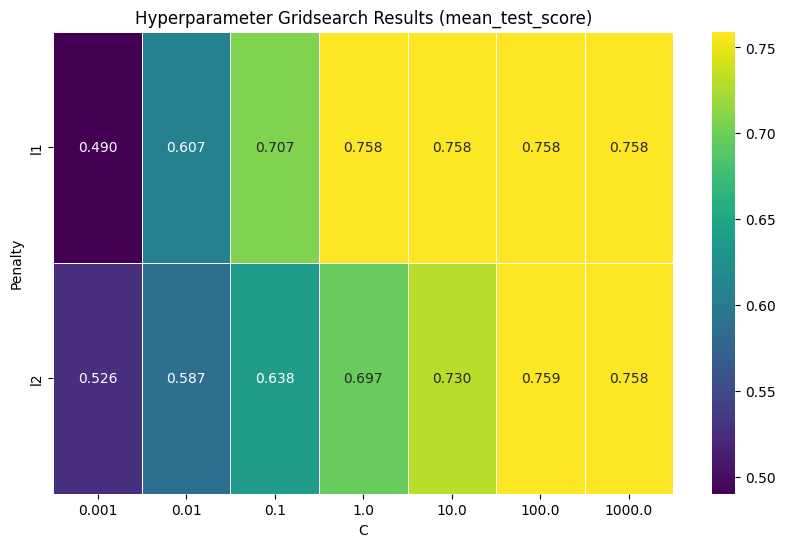

In [85]:
# Fit the GridSearchCV again
grid_search = GridSearchCV(lrBOW, hyperparameters, cv=5)
grid_search.fit(X_train_val_BOW, Y_train_val_BOW)

# Get the results of the grid search
cv_results = grid_search.cv_results_

# Create a DataFrame from the cv_results
df_cv_results = pd.DataFrame(cv_results)

# Extract the mean_test_score values for each hyperparameter combination
scores_matrix = df_cv_results.pivot(index='param_penalty', columns='param_C', values='mean_test_score')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(scores_matrix, annot=True, fmt=".3f", linewidths=.5, cmap='viridis')
plt.title('Hyperparameter Gridsearch Results (mean_test_score)')
plt.xlabel('C')
plt.ylabel('Penalty')
plt.show()


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [28]:
vectorizer = TfidfVectorizer()

In [29]:
def extract_features_and_labels_tfidf(dataframe, fit_vectorizer=False):

    labels = dataframe['label'].values.astype(int)
    messages = dataframe['clean']

    if fit_vectorizer:
        feature_matrix = vectorizer.fit_transform(messages)
    else:
        feature_matrix = vectorizer.transform(messages)

    return feature_matrix, labels

In [86]:
def train_logistic_regression_tfidf(train_df, val_df, test_df):
    
    X_train_TFIDF, Y_train_TFIDF = extract_features_and_labels_tfidf(train_df, fit_vectorizer = True)

    X_val_TFIDF, Y_val_TFIDF = extract_features_and_labels_tfidf(val_df)

    X_test_TFIDF, Y_test_TFIDF = extract_features_and_labels_tfidf(test_df)



    lr_tfidf = LogisticRegression(solver='liblinear', max_iter=30000)
    grid_search = GridSearchCV(lr_tfidf, hyperparameters, cv=5)
    grid_search.fit(X_train_TFIDF, Y_train_TFIDF)
    best_params = grid_search.best_params_
    print('Best Parameters:', best_params)
    cv_results = grid_search.cv_results_
    df_cv_results = pd.DataFrame(cv_results)


    lr_tfidf = LogisticRegression(solver='liblinear', max_iter=30000, **best_params)
    lr_tfidf.fit(X_train_TFIDF, Y_train_TFIDF)
    # Extract the mean_test_score values for each hyperparameter combination
    scores_matrix = df_cv_results.pivot(index='param_penalty', columns='param_C', values='mean_test_score')

# Create a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(scores_matrix, annot=True, fmt=".3f", linewidths=.5, cmap='viridis')
    plt.title('Hyperparameter Gridsearch Results (mean_test_score)')
    plt.xlabel('C')
    plt.ylabel('Penalty')
    plt.show()  


    val_pred = lr_tfidf.predict(X_val_TFIDF)
    print("Logistic Regression (TF-IDF) Validation Accuracy:", accuracy_score(Y_val_TFIDF, val_pred))
    print(classification_report(Y_val_TFIDF, val_pred))

    test_pred = lr_tfidf.predict(X_test_TFIDF)
    print("Logistic Regression (TF-IDF) Test Accuracy:", accuracy_score(Y_test_TFIDF, test_pred))
    print(classification_report(Y_test_TFIDF, test_pred))

Best Parameters: {'C': 1000, 'penalty': 'l2'}


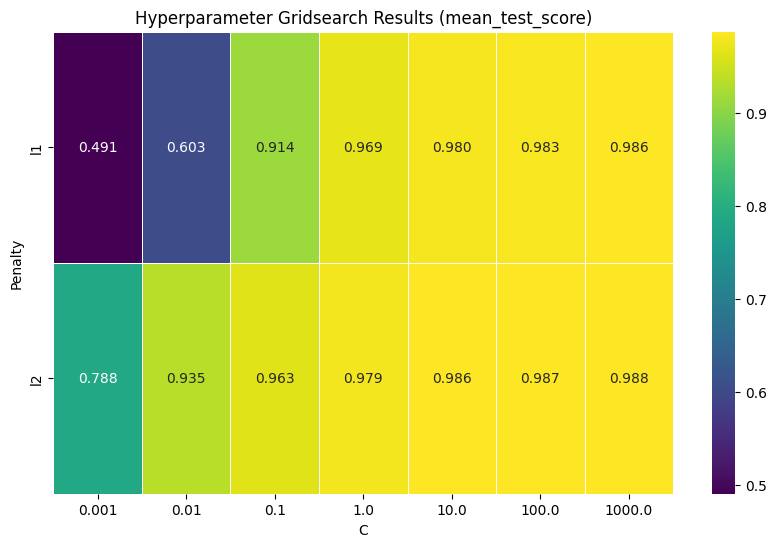

Logistic Regression (TF-IDF) Validation Accuracy: 0.9867139061116031
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3308
           1       0.98      0.99      0.99      3466

    accuracy                           0.99      6774
   macro avg       0.99      0.99      0.99      6774
weighted avg       0.99      0.99      0.99      6774

Logistic Regression (TF-IDF) Test Accuracy: 0.989211866946359
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1665
           1       0.98      0.99      0.99      1672

    accuracy                           0.99      3337
   macro avg       0.99      0.99      0.99      3337
weighted avg       0.99      0.99      0.99      3337



In [87]:
train_logistic_regression_tfidf(train_df, val_df, test_df)

In [77]:
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def train_naive_bayes_bow(train_df, val_df, test_df):
    
    X_train_BOW, Y_train_BOW = extract_features_and_labels(train_df)

    X_val_BOW, Y_val_BOW = extract_features_and_labels(val_df)

    X_test_BOW, Y_test_BOW = extract_features_and_labels(test_df)

    # Define the hyperparameters and the values to test
    hyperparameters = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'norm': [True, False]
    }

    # Initialize the Naive Bayes model
    cnb_bow = ComplementNB()

    # Initialize the GridSearchCV
    grid_search = GridSearchCV(cnb_bow, hyperparameters, cv=5)

    # Fit the GridSearchCV to the training data
    grid_search.fit(X_train_BOW, Y_train_BOW)

    # Get the best parameters
    best_params = grid_search.best_params_
    print('Best Parameters:', best_params)

    # Train the model with the best parameters
    cnb_bow = ComplementNB(**best_params)
    cnb_bow.fit(X_train_BOW, Y_train_BOW)

    # Get the results of the grid search
    cv_results = grid_search.cv_results_

    # Create a DataFrame from the cv_results
    df_cv_results = pd.DataFrame(cv_results)

    # Extract the mean_test_score values for each alpha
    scores_matrix = df_cv_results.pivot(index='param_alpha', columns='param_norm', values='mean_test_score')
    
    # Create a heatmap for the mean_test_score values
    scores_matrix = df_cv_results.pivot(index='param_alpha', columns='param_norm', values='mean_test_score')
    plt.figure(figsize=(10, 6))
    sns.heatmap(scores_matrix, annot=True, fmt=".3f", cmap='viridis')
    plt.title('Hyperparameter Gridsearch Results (mean_test_score)')
    plt.xlabel('Norm')
    plt.ylabel('Alpha')
    plt.show()

    # Validation evaluation
    val_pred = cnb_bow.predict(X_val_BOW)
    print("Naive Bayes (BoW) Validation Accuracy:", accuracy_score(Y_val_BOW, val_pred))
    print(classification_report(Y_val_BOW, val_pred))

    # Test evaluation
    test_pred = cnb_bow.predict(X_test_BOW)
    print("Naive Bayes (BoW) Test Accuracy:", accuracy_score(Y_test_BOW, test_pred))
    print(classification_report(Y_test_BOW, test_pred))




Best Parameters: {'alpha': 1000, 'norm': False}


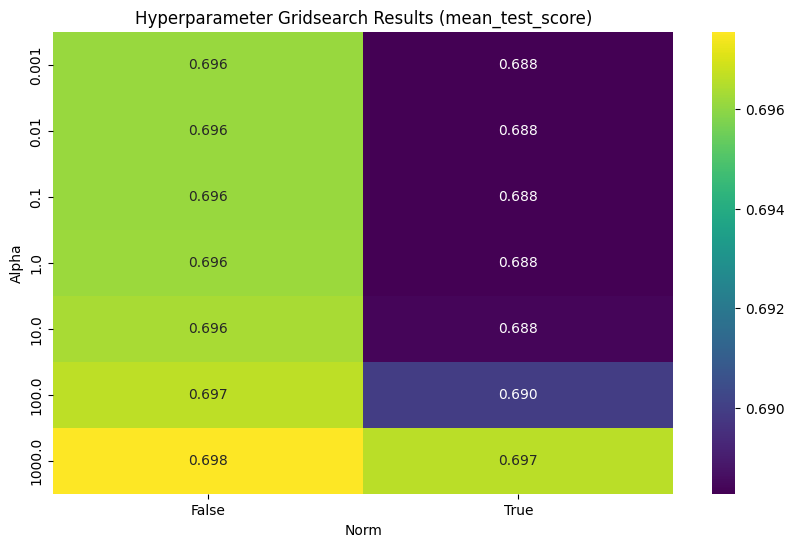

Naive Bayes (BoW) Validation Accuracy: 0.688957779746088
              precision    recall  f1-score   support

           0       0.65      0.79      0.71      3308
           1       0.75      0.59      0.66      3466

    accuracy                           0.69      6774
   macro avg       0.70      0.69      0.69      6774
weighted avg       0.70      0.69      0.69      6774

Naive Bayes (BoW) Test Accuracy: 0.7075217261012886
              precision    recall  f1-score   support

           0       0.67      0.80      0.73      1665
           1       0.76      0.61      0.68      1672

    accuracy                           0.71      3337
   macro avg       0.72      0.71      0.70      3337
weighted avg       0.72      0.71      0.70      3337



In [88]:
train_naive_bayes_bow(train_df, val_df, test_df)

In [79]:
def train_naive_bayes_tfidf(train_df, val_df, test_df):
    X_train_TFIDF, Y_train_TFIDF = extract_features_and_labels_tfidf(train_df, fit_vectorizer = True)

    X_val_TFIDF, Y_val_TFIDF = extract_features_and_labels_tfidf(val_df)

    X_test_TFIDF, Y_test_TFIDF = extract_features_and_labels_tfidf(test_df)

    hyperparameters = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'norm': [True, False]
    }

    cnb_tfidf = ComplementNB()
    cnb_tfidf.fit(X_train_TFIDF, Y_train_TFIDF)

    grid_search = GridSearchCV(cnb_tfidf, hyperparameters, cv=5)

    # Fit the GridSearchCV to the training data
    grid_search.fit(X_train_BOW, Y_train_BOW)

    # Get the best parameters
    best_params = grid_search.best_params_
    print('Best Parameters:', best_params)
    
    cnb_tfidf = ComplementNB(**best_params)
    cnb_tfidf.fit(X_train_TFIDF, Y_train_TFIDF)

    # Get the results of the grid search
    cv_results = grid_search.cv_results_

    # Create a DataFrame from the cv_results
    df_cv_results = pd.DataFrame(cv_results)

    scores_matrix = df_cv_results.pivot(index='param_alpha', columns='param_norm', values='mean_test_score')
    
    # Create a heatmap for the mean_test_score values
    scores_matrix = df_cv_results.pivot(index='param_alpha', columns='param_norm', values='mean_test_score')
    plt.figure(figsize=(10, 6))
    sns.heatmap(scores_matrix, annot=True, fmt=".3f", cmap='viridis')
    plt.title('Hyperparameter Gridsearch Results (mean_test_score)')
    plt.xlabel('Norm')
    plt.ylabel('Alpha')
    plt.show()


    # Validation evaluation
    val_pred = cnb_tfidf.predict(X_val_TFIDF)
    print("Naive Bayes (TF-IDF) Validation Accuracy:", accuracy_score(Y_val_TFIDF, val_pred))
    print(classification_report(Y_val_TFIDF, val_pred))

    # Test evaluation
    test_pred = cnb_tfidf.predict(X_test_TFIDF)
    print("Naive Bayes (TF-IDF) Test Accuracy:", accuracy_score(Y_test_TFIDF, test_pred))
    print(classification_report(Y_test_TFIDF, test_pred))

Best Parameters: {'alpha': 0.001, 'norm': True}


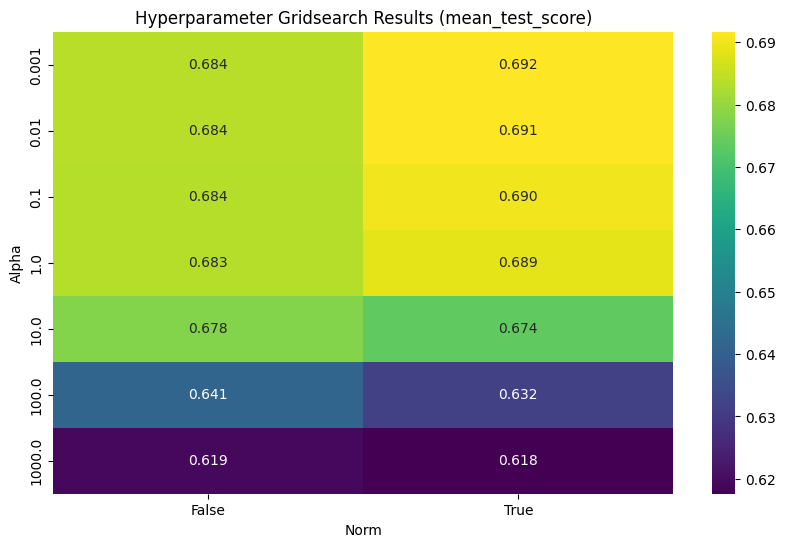

Naive Bayes (TF-IDF) Validation Accuracy: 0.8201948627103631
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      3308
           1       1.00      0.65      0.79      3466

    accuracy                           0.82      6774
   macro avg       0.87      0.82      0.82      6774
weighted avg       0.87      0.82      0.82      6774

Naive Bayes (TF-IDF) Test Accuracy: 0.8145040455498951
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1665
           1       1.00      0.63      0.77      1672

    accuracy                           0.81      3337
   macro avg       0.86      0.81      0.81      3337
weighted avg       0.86      0.81      0.81      3337



In [80]:
train_naive_bayes_tfidf(train_df, val_df, test_df)

In [ ]:
input_email = ["You have 18 unread notifications to review"]
input_data_features = feature_extraciton.transform(input_email)

prediction = lrTFIDF.predict(input_data_features)

print(prediction)

if(prediction[0]==1):
    print('Spam mail')

else:
    print('Ham mail')
